<a href="https://colab.research.google.com/github/nawaltahir/DEP/blob/main/Customer_Churn_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# install modelbit
!pip install modelbit

# run on top of your notebook
import modelbit
mb = modelbit.login()

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
training_data = pd.read_csv('/content/drive/MyDrive/Datasets/customer_churn_dataset-training-master.csv')
testing_data = pd.read_csv('/content/drive/MyDrive/Datasets/customer_churn_dataset-testing-master.csv')

In [9]:
# Features and target variable
X_train = training_data.drop(columns=['Age', 'Gender', 'CustomerID'])
y_train = training_data['Churn']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = testing_data.drop(columns=['Age', 'Gender'])
y_test = testing_data['Churn']


In [10]:
# Check for missing values in y_train
print(y_train.isnull().sum())

1


In [11]:
# prompt: remove the nan from y_train

# Remove rows with NaN values in y_train
X_train = X_train[~y_train.isnull()]
y_train = y_train[~y_train.isnull()]


In [12]:
X_train['Subscription Type'] = X_train['Subscription Type'].replace({ 'Basic': 0, 'Standard': 1, 'Premium': 2})
X_train['Contract Length'] = X_train['Contract Length'].replace({ 'Quarterly': 0, 'Monthly': 1, 'Annual': 2})
X_train.head()

,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,39.0,14.0,5.0,18.0,1,2,932.0,17.0,1.0
1,49.0,1.0,10.0,8.0,0,1,557.0,6.0,1.0
2,14.0,4.0,6.0,18.0,0,0,185.0,3.0,1.0
3,38.0,21.0,7.0,7.0,1,1,396.0,29.0,1.0
4,32.0,20.0,5.0,8.0,0,1,617.0,20.0,1.0


In [13]:
X_test['Subscription Type'] = X_test['Subscription Type'].replace({ 'Basic': 0, 'Standard': 1, 'Premium': 2})
X_test['Contract Length'] = X_test['Contract Length'].replace({ 'Quarterly': 0, 'Monthly': 1, 'Annual': 2})
X_test.head()

,CustomerID,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,25,14,4,27,0,1,598,9,1
1,2,28,28,7,13,1,1,584,20,0
2,3,27,10,2,29,2,2,757,21,0
3,4,9,12,5,17,2,0,232,18,0
4,5,58,24,9,2,1,2,533,18,0


In [18]:
numeric_features = ['Tenure','Usage Frequency','Support Calls',	'Payment Delay',	'Total Spend',	'Last Interaction',	'Churn']
categorical_features = ['Subscription Type', 'Contract Length']

In [19]:
# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    #('bin', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [20]:
# Combine all transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=200))])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure', 'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction',
                                                   'Churn']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Subscription Type',
                                                   'Contract Length'])])),
                ('classifier', LogisticRegression(max_iter=200))])

In [21]:
# print train and test set shape
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# generate predictions
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# test accuracy on X_test
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

X_train: (440832, 9)
X_test: (64374, 10)
y_train: (440832,)
y_test: (64374,)
1.0


In [22]:
for c_value in [0.0001]:
  pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', LogisticRegression(C=c_value, penalty='l2', max_iter=200))
  ])
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Test accuracy with C={c_value}:", accuracy)

Test accuracy with C=0.0001: 0.9794637586603288


In [23]:
for max_iter_value in [100, 200, 300]:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=1, penalty='l2', max_iter=max_iter_value))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy with max_iter={max_iter_value}:", accuracy)

Test accuracy with max_iter=100: 1.0
Test accuracy with max_iter=200: 1.0
Test accuracy with max_iter=300: 1.0


In [24]:
# prompt: fine tune the model for increasing accuracy

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Define the parameter grid for hyperparameter tuning
param_grid = {
    #'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.0001],
    'classifier__penalty': ['l2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("LR Test accuracy:", accuracy)

# Try different classifiers
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("RF Test accuracy:",accuracy_score(y_test,y_pred))

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('classifier', SVC(probability=True))])
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# print(accuracy_score(y_test,y_pred))


Best parameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2'}
Best score: 1.0
LR Test accuracy: 0.9794637586603288
RF Test accuracy: 0.988970702457514


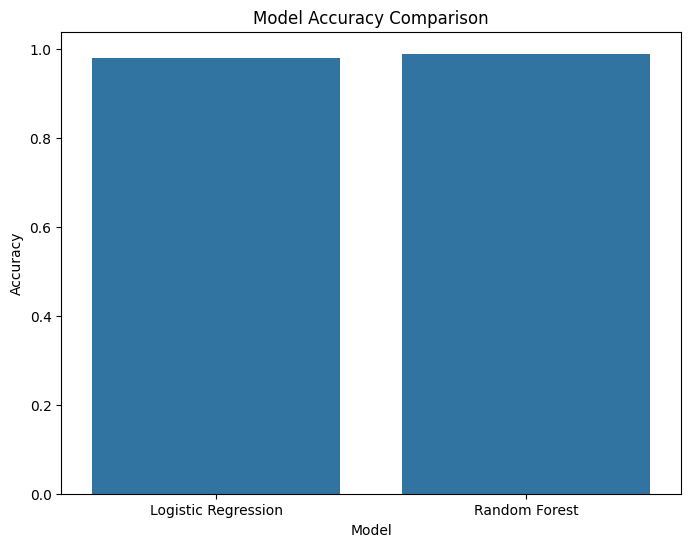

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the accuracy results
accuracy_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy, accuracy_score(y_test, y_pred)]
})

# Plot the accuracy using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


In [31]:
import modelbit
mb = modelbit.login()

In [49]:
import pandas as pd
import numpy as np
# first define function
def predict_churn_default(Tenure: float, Usage_Frequency: float, Support_Calls: float,	Payment_Delay: float,	Total_Spend: float,	Last_Interaction : float, Contract_Length: int, Subscription_Type: int, Churn: int)-> float:

  """
  Predict the probability of loan default using a pre-trained machine learning pipeline.

  Args:
      Age (int): Applicant's age.
      Annual_Income (float): Applicant's annual income.
      Credit_Score (int): Applicant's credit score.
      Employment_Years (float): Number of years employed.
      Loan_Amount_Requested (float): Requested loan amount.

  Returns:
      float: Probability of loan default.
  """
  columns = ['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Contract Length', 'Subscription Type', 'Churn']
  return pipeline.predict_proba(pd.DataFrame([[Tenure, Usage_Frequency, Support_Calls,  Payment_Delay,  Total_Spend,    Last_Interaction, Contract_Length, Subscription_Type, Churn]],
                                             columns = columns))[:,1]


In [50]:
predict_churn_default(32, 10, 3, 4, 930, 24, 1, 0, 1)

array([1.])

In [52]:
# deploy predict_loan_default
mb.deploy(predict_churn_default)

ModelbitError: Not Authenticated